In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect
from numpy.fft import fft
from numpy.fft import fftshift


class LogScaler:
    #Log normalization and data scaling
    
    def __init__(self):
        self._min0 = None
        self._max = None
        pass

    def fit(self, X, y=None):
        self._min0 = X.min(axis=0)
        self._max = np.log(X + np.abs(self._min0) + 1).max()

    def fit_transform(self, X, y=None):
        self._min0 = X.min(axis=0)
        X_norm = np.log(X + np.abs(self._min0) + 1)
        self._max = X_norm.max()
        return X_norm / self._max

    def transform(self, X, y=None):
        X_norm = np.log(X + np.abs(self._min0) + 1).clip(0, None)
        return (X_norm / self._max).clip(0, 1)


class FftTransformer:
    # Image transformer based on fast fourier transform

    def __init__(self, pixels=124):
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        self._xrot = None

    def fft_fit(self,X):     
        z1_lst=[]
        z2_lst=[]

        for cur_x in range(len(X)):
            x_ft = fftshift(fft(X[cur_x]))
                 
            real_lst =[0]*len(x_ft)
            imag_lst= [0]*len(x_ft)

            for i in range(len(x_ft)):
                real_lst[i] = x_ft[i].real
                imag_lst[i] = x_ft[i].imag

            q1, q3 = np.percentile(sorted(real_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(real_lst)):
                if real_lst[i] <= lower_bound or real_lst[i] >= upper_bound:
                    outliers.append(real_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                real_lst[outliers_idx[i]]=0
            
            # imag 
            q1, q3 = np.percentile(sorted(imag_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(imag_lst)):
                if imag_lst[i] <= lower_bound or imag_lst[i] >= upper_bound:
                    outliers.append(imag_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                imag_lst[outliers_idx[i]]=0

            z1_lst.append(np.array(real_lst))
            z2_lst.append(np.array(imag_lst))
    
        z1_lst = np.mean(np.array(z1_lst),axis=0) 
        z2_lst = np.mean(np.array(z2_lst),axis=0)

        real_mt = np.empty(shape=(x_ft.shape[0],1))
        real_mt.fill(0)
        imag_mt = np.empty(shape=(x_ft.shape[0],1))
        imag_mt.fill(0)

        for i in range(len(x_ft)):
            cur_real = z1_lst[i]
            real_mt[i] = cur_real

            cur_imag = z2_lst[i]
            imag_mt[i] = cur_imag

        z1 = real_mt
        z2 = imag_mt
        full_mt = np.hstack((z1,z2))
    
        return full_mt

    def fit(self, X, y=None, plot=False):
        x_new = self.fft_fit(X)        

        # get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices

        hull_points = x_new[chvertices]

        # get minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)
        
        # matrix rotation
        self._xrot = np.dot(mbr_rot, x_new.T).T
        
        # get feature coordinates from pixel dimension
        self._calculate_coords()

        #  rotation diagram plot
        if plot is True:
            plt.scatter(x_new[:, 0], x_new[:, 1], s=1,
                        cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
            plt.fill(x_new[chvertices, 0], x_new[chvertices, 1],
                     edgecolor='r', fill=False)
            plt.fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        # Image matrix dimensions
        # Returns:
        #     tuples: (height, width)

        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        # set image matrix dimension

        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):

        # Calculate matrix coordinates of each feature based on the pixel dimensions


        cur_xrp = self._xrot[:, 0]
        cur_yrp = self._xrot[:, 1] 

        ax0_coord = np.digitize(
            cur_xrp,
            bins=np.linspace(min(cur_xrp), max(cur_xrp),
                             self._pixels[0])
        ) - 1
        ax1_coord = np.digitize(
            cur_yrp,
            bins=np.linspace(min(cur_yrp), max(cur_yrp),
                             self._pixels[1])
        ) - 1

        self._coords = np.stack((ax0_coord, ax1_coord), axis=1)

    def transform(self, X):
 
        img_coords = pd.DataFrame(np.vstack((
            self._coords.T,
            X
        )).T).groupby([0, 1], as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

    
        img_matrices = np.array([self._mat_to_rgb(m) for m in img_matrices])
        
        return img_matrices

    def img_trans(self, X):
        img_coords = pd.DataFrame(np.vstack((
            self._coords.T,
            X
        )).T).groupby([0, 1], as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

    
        img_matrices = np.array([m for m in img_matrices])
        
        return img_matrices

    def fit_transform(self, X, **kwargs):

        self.fit(X)
        return self.transform(X, **kwargs)

    def feature_density_matrix(self):

        fdmat = np.zeros(self._pixels)
        np.add.at(fdmat, tuple(self._coords.T), 1)
        return fdmat

    def coords(self):
        #Get feature coordinates

        return self._coords.copy()

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.
        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.
        Args:
            hull_points : an nx2 matrix of hull coordinates
        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2
        # calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)
        # find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            -np.sin(angles),
            np.sin(angles),
            np.cos(angles)]).T
        rotations = rotations.reshape((-1, 2, 2))
        # apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)
        # find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)
        # find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)
        # return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]
        # generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

    @staticmethod
    def _mat_to_rgb(mat):
        """Convert image matrix to numpy rgb format
        Args:
            mat: {array-like} (M, N)
        Returns:
            An numpy.ndarry (M, N, 3) with orignal values repeated across
            RGB channels.
        """
        return np.repeat(mat[:, :, np.newaxis], 3, axis=2)

In [3]:
import pandas as pd
import csv 
import numpy as np 
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [4]:
df = pd.read_csv('/content/drive/MyDrive/USYD/2021 S1/INFO4001/yan-RowCount_modified.csv',header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [5]:
def shuffle_data(x):
    
    # save header
    tmp_head = x[0]

    #remove header 
    x = x[1:]

    # shuffle by row 
    np.random.shuffle(x)

    #stack header
    x = np.vstack((tmp_head,x))

    # shuffle by column after T transformation 
    x = x.T 

    tmp_head = x[0]
    x = x[1:]

    np.random.shuffle(x)

    x = np.vstack((tmp_head,x))

    return x 

In [6]:
def remove_invalid_val(mt):
    inval_lst= ['nan','alpha.contaminated', 'beta.contaminated', 
    'delta.contaminated', 'Excluded', 'gamma.contaminated', 'miss', 'NA',
    'not applicable', 'unclassified', 'unknown', 'Unknown', 'zothers']
    print("before shape {}".format(mt.shape))
    lst = mt[0].astype(str)
    d_lst=[]

    for i in range(len(lst)):
        for j in range(len(inval_lst)):

            if lst[i] == inval_lst[j]:
                d_lst.append(i)
    print(len(d_lst))
    mt = np.delete(mt,d_lst,axis=1)
    print("after shape {}".format(mt.shape))
    return mt

In [7]:
# data preprocessing and data split 

mt = df.to_numpy()
mt = mt.T

mt = remove_invalid_val(mt)

#shuffle dataset by rows and cols
mt = shuffle_data(mt)

# get type for each sample 
mt_Y = mt.T[0][1:]

mt1 = mt[:,1:]
mt_X = mt1[1:]
mt_X = mt_X.astype('float64')


unique_classes = np.unique(mt_Y)

# split data to train and test 
x_train, x_test, y_train, y_test = train_test_split(
    mt_X, mt_Y, test_size=0.2,stratify=mt_Y, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(unique_classes)
print(len(unique_classes))

before shape (19596, 91)
0
after shape (19596, 91)
(72, 19595) (18, 19595) (72,) (18,)
['16cell' '2cell' '4cell' '8cell' 'blast' 'zygote']
6


In [8]:
ln = LogScaler()

x_train_norm = ln.fit_transform(x_train)
x_test_norm = ln.transform(x_test)


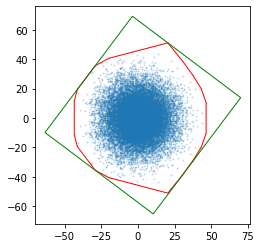

In [9]:
it = FftTransformer(pixels=124)
_ = it.fit(x_train_norm, plot=True)

In [10]:
x_train_img = it.transform(x_train_norm)
x_train_img.shape

(72, 124, 124, 3)

In [11]:
x_density_img = it.img_trans(x_train_norm)
x_density_img.shape

(72, 124, 124)

In [12]:
x_test_img = it.transform(x_test_norm)
x_test_img.shape

(18, 124, 124, 3)

Train img
2cell
4cell
16cell
16cell
16cell
8cell
blast
blast
zygote
8cell


<Figure size 1080x288 with 0 Axes>

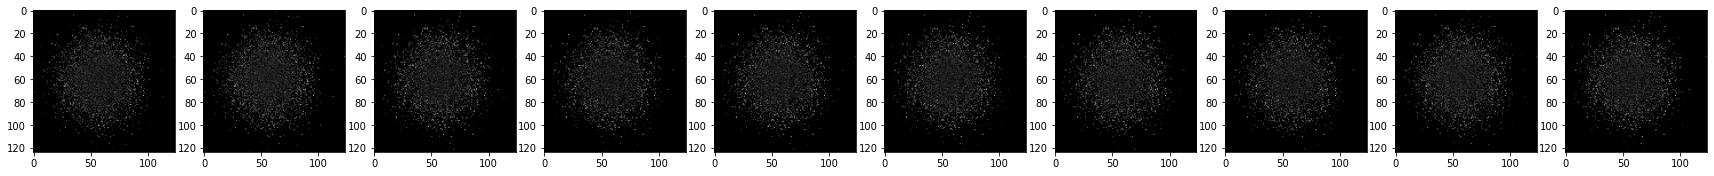

In [13]:
print("Train img")
plt.figure(figsize=(15,4))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):
    axarr[i].imshow(x_train_img[i])
    print(y_train[i])

Test img
2cell
4cell
16cell
16cell
16cell
8cell
blast
blast
zygote
8cell


<Figure size 1080x288 with 0 Axes>

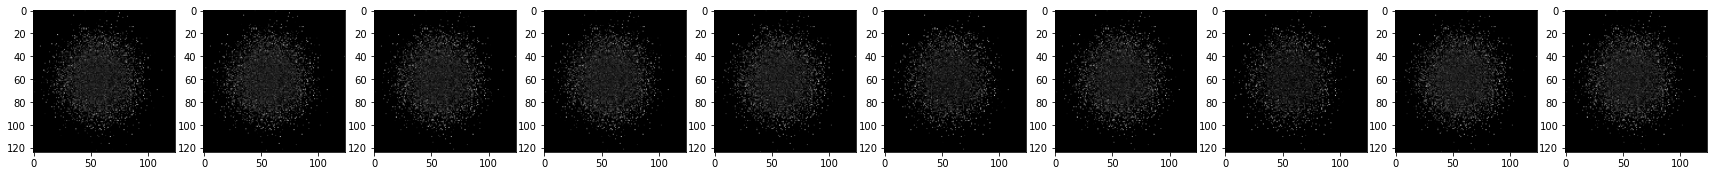

In [14]:
print("Test img")
plt.figure(figsize=(15,4))
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):   
    axarr[i].imshow(x_test_img[i])
    print(y_train[i])


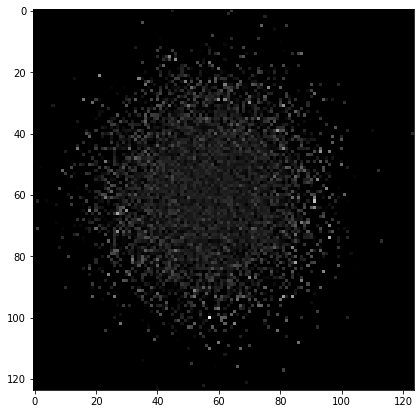

In [15]:
plt.figure(figsize=(10,7))
plt.imshow(x_train_img[0])

(124, 124)


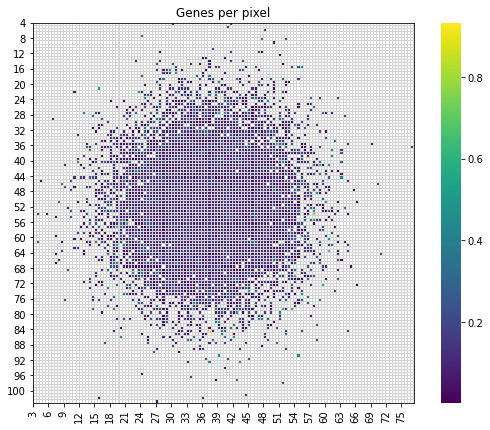

In [16]:
plt.figure(figsize=(10, 7))

fdm = x_density_img[0]
fdm[fdm == 0] = np.nan
print(fdm.shape)


ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras import layers
import numpy as np

In [18]:

label = unique_classes.tolist()

n_lst=[]
for i in range(len(y_train)):
  for j in range(len(label)):
    if y_train[i] == label[j]:

      n_lst.append(j)

y_new_train = np.array(n_lst,dtype='float64')

n_lst=[]
for i in range(len(y_test)):
  for j in range(len(label)):
    if y_test[i] == label[j]:
      n_lst.append(j)

y_new_test = np.array(n_lst,dtype='float64')

In [19]:
df_y_train = to_categorical(y_new_train,num_classes=len(label))

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau


model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=(124,124,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3) ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(len(label)))
model.add(Activation('sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, min_delta=1e-4, mode='auto')

model.fit(x_train_img, df_y_train, batch_size=32, epochs=90, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.2)

Epoch 1/90
2/2 [==============================] - 32s 536ms/step - loss: 2.6683 - accuracy: 0.2105 - val_loss: 2.9306 - val_accuracy: 0.0000e+00
Epoch 2/90
2/2 [==============================] - 0s 36ms/step - loss: 1.7507 - accuracy: 0.2632 - val_loss: 2.1590 - val_accuracy: 0.1333
Epoch 3/90
2/2 [==============================] - 0s 42ms/step - loss: 1.6285 - accuracy: 0.2456 - val_loss: 1.7331 - val_accuracy: 0.3333
Epoch 4/90
2/2 [==============================] - 0s 44ms/step - loss: 1.6222 - accuracy: 0.3509 - val_loss: 1.6876 - val_accuracy: 0.6667
Epoch 5/90
2/2 [==============================] - 0s 43ms/step - loss: 1.6145 - accuracy: 0.8596 - val_loss: 1.6391 - val_accuracy: 0.7333
Epoch 6/90
2/2 [==============================] - 0s 46ms/step - loss: 1.5009 - accuracy: 0.8596 - val_loss: 1.5905 - val_accuracy: 0.5333
Epoch 7/90
2/2 [==============================] - 0s 45ms/step - loss: 1.3312 - accuracy: 0.6842 - val_loss: 1.6222 - val_accuracy: 0.5333
Epoch 8/90
2/2 [=====

In [21]:
df_y_test = to_categorical(y_new_test,num_classes=len(label))

val_loss, val_acc = model.evaluate(x_test_img,df_y_test)
print(val_loss, val_acc)

1/1 [==============================] - 0s 174ms/step - loss: 0.0103 - accuracy: 1.0000
0.010333791375160217 1.0


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_pred = model.predict(x_test_img)
y_pred = np.argmax(y_pred,axis=1)

out_acc = accuracy_score(y_new_test, y_pred)
out_f1 = f1_score(y_new_test, y_pred,average ='micro')

print("Accuracy: {}".format(round(out_acc,4)))
print("F1 Score(micro): {}".format(round(out_f1,4)))

out_f1 = f1_score(y_new_test, y_pred,average ='macro')
print("F1 Score(macro): {}".format(round(out_f1,4)))

out_f1 = f1_score(y_new_test, y_pred,average ='weighted')
print("F1 Score(weighted): {}".format(round(out_f1,4)))

Accuracy: 1.0
F1 Score(micro): 1.0
F1 Score(macro): 1.0
F1 Score(weighted): 1.0


In [23]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay


In [24]:
cm = confusion_matrix(y_new_test,y_pred)

In [25]:
print(label)

['16cell', '2cell', '4cell', '8cell', 'blast', 'zygote']


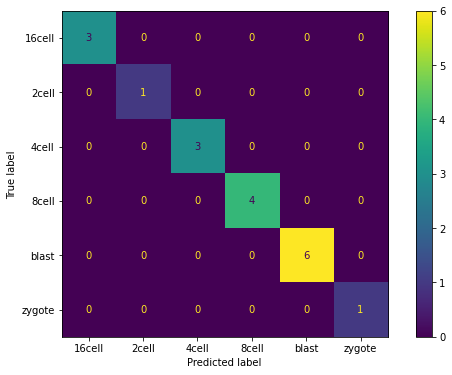

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label)


disp = disp.plot()
plt.gcf().set_size_inches(10,6)
#plt.title("deng-read")
plt.show()